<a href="https://colab.research.google.com/github/EsmeBarker/Collab/blob/main/copy_of_unit4exerciessf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
aa_encode = pd.Categorical(cs_data['aa'])
aa_coords = {"aa": aa_encode.categories}
aa_idx = aa_encode.codes
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
with pm.Model(coords=aa_coords) as cs_h_model_studentt:
    μ_mu = pm.StudentT('μ_mu', nu = 30, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu = 30, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam= 1/30)

    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd, nu = μ_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 30, sigma = 10,
                      dims = "aa")

    nu_y = pm.Exponential('nu_y', lam=1/30)

    y = pm.StudentT('y', mu = μ[aa_idx], sigma = σ[aa_idx], nu = nu_y, observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
aa_encode = pd.Categorical(cs_data['aa'])
aa_coords = {"aa": aa_encode.categories}
aa_idx = aa_encode.codes
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
with pm.Model(coords=aa_coords) as cs_h_model_normal:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)


    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h_0 = pm.sample()

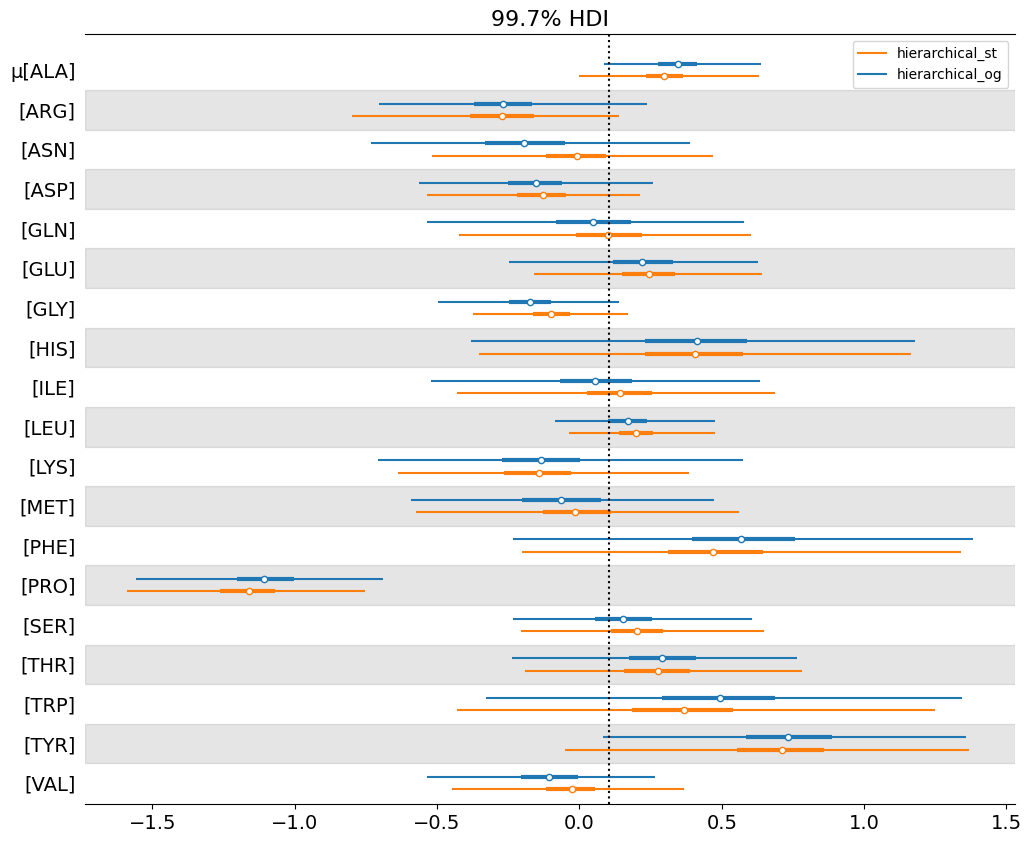

In [ ]:

axes = az.plot_forest([idata_cs_h_0, idata_cs_h], kind="forestplot",
                      model_names=['hierarchical_og', 'hierarchical_st'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model_studentt, extend_inferencedata=True)

<Axes: xlabel='y'>

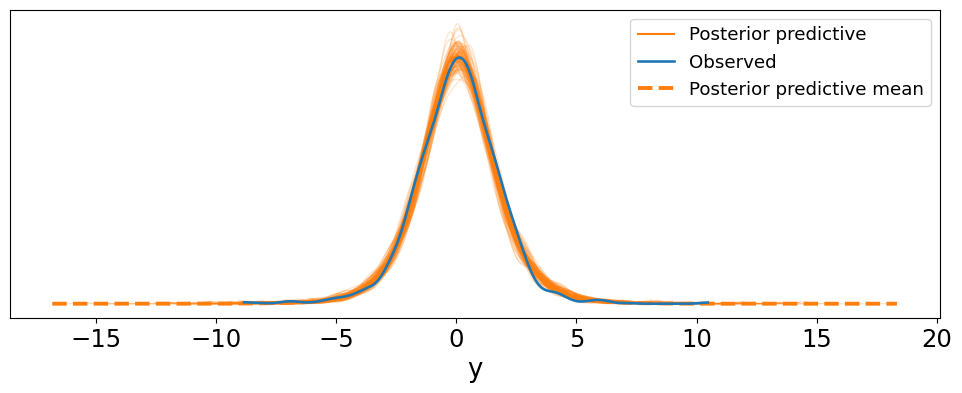

In [ ]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In [ ]:
pm.sample_posterior_predictive(idata_cs_h_0, model=cs_h_model_normal, extend_inferencedata=True)

<Axes: xlabel='y'>

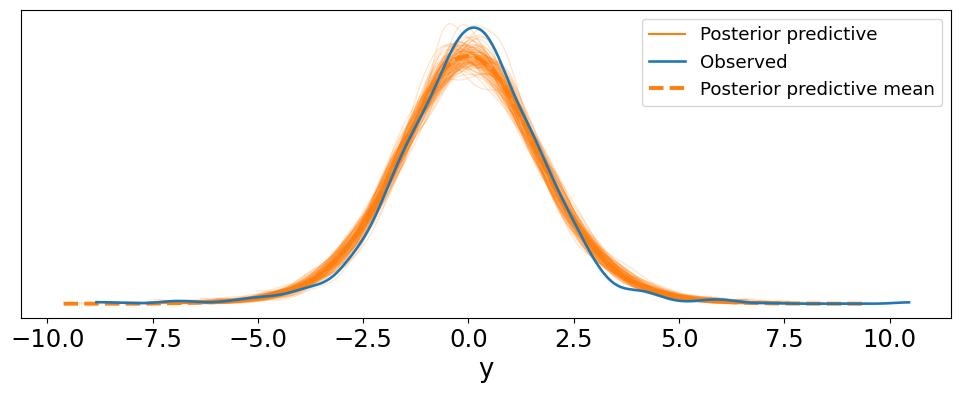

In [ ]:
az.plot_ppc(idata_cs_h_0, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

the student t model fit the data better

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:
import pandas as pd
import pymc as pm
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}
with pm.Model(coords = sccr_coords) as sccr_model:


    μ_p = pm.Beta('μ_p', mu = 1/11, nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)

    idata_sccr = pm.sample()

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.004 1.0 1.001 1.002 ... 1.003 0.9994 1.003
    μ_p      (pos) float64 32B 1.001 1.0 1.041 1.002
    ν_p      (pos) float64 32B 1.014 1.001 1.071 1.008

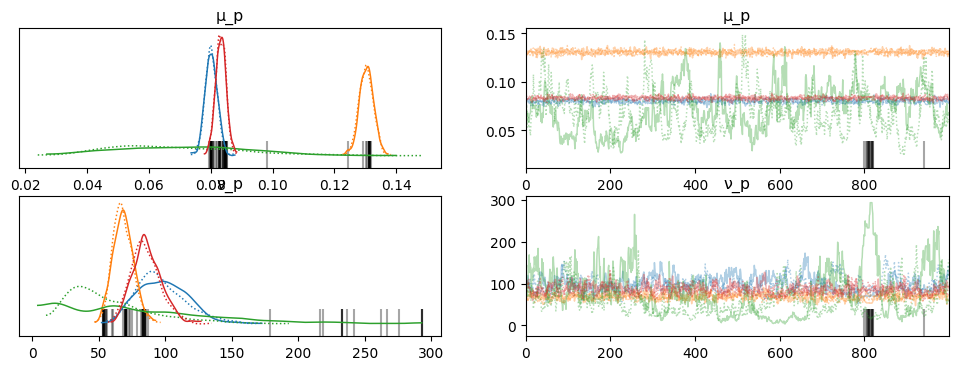

In [ ]:
az.plot_trace(idata_sccr, var_names=['μ_p', 'ν_p']);
az.rhat(idata_sccr)

The graphs from the plot trace look very similar to the ones from the hierarchical soccer model, except some differences in specifics of the numbers and sharper peaks. They seem a bit less accurate.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

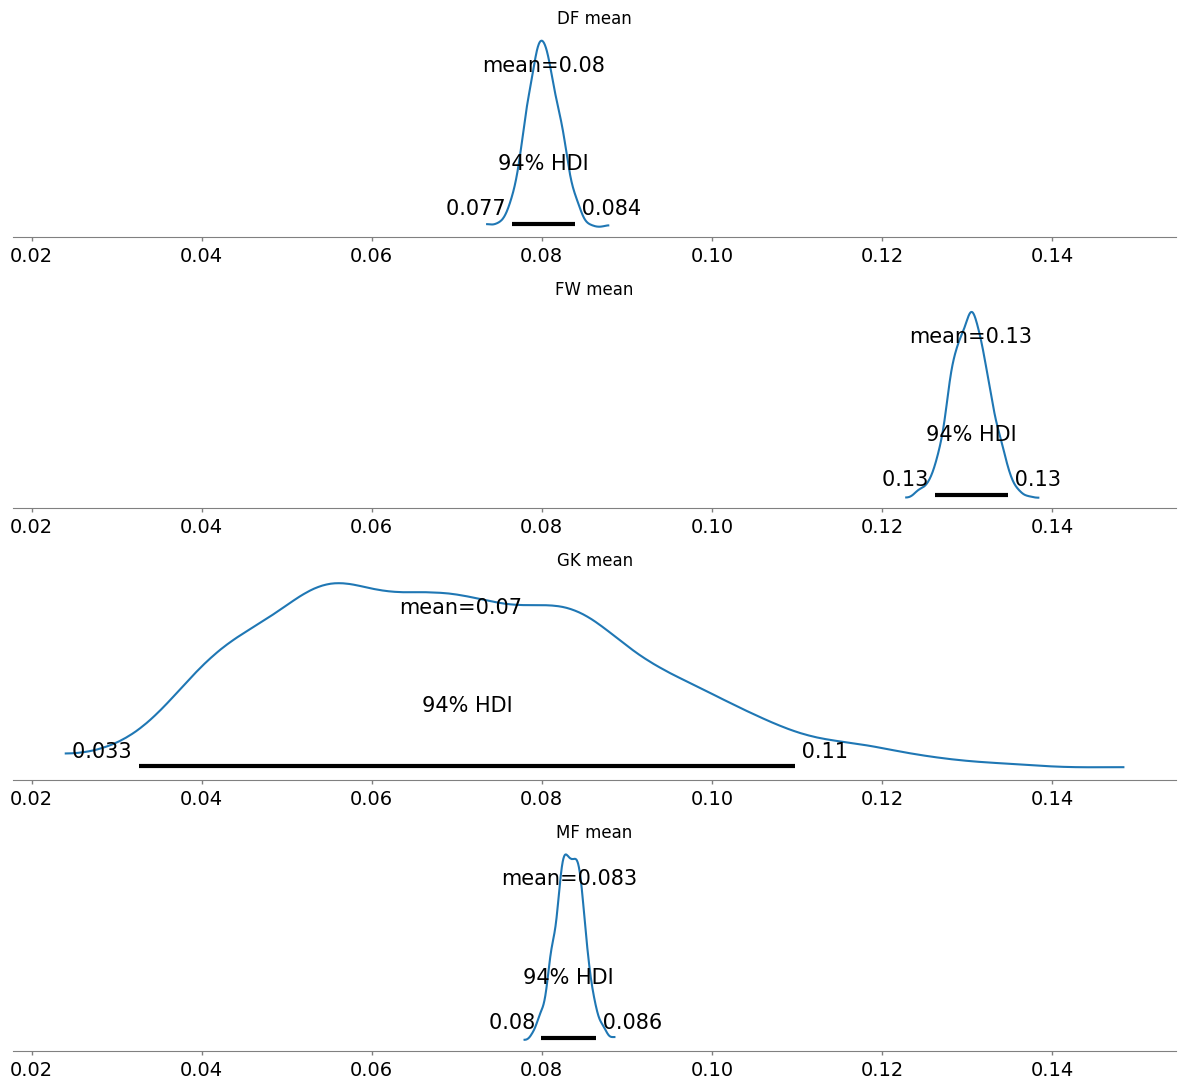

In [ ]:
#originally did this on my own, and then gemeni had suggestions to make it more efficient and fix an error with variable naming that I had
fig, axes = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

positions = sccr_coords['pos'].values # Get position names: ['DF', 'FW', 'GK', 'MF']

for i, pos_name in enumerate(positions):
    az.plot_posterior(idata_sccr.posterior.sel(pos=pos_name), var_names='μ_p', ax=axes[i])
    axes[i].set_title(f"{pos_name} mean")

plt.tight_layout()

This posterior seems very similar to the posteriors in the heirarchical model. though they seem a little bit less "bumpy" at the peaks.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
#gemeni helped me remove the goalkeepers from the data set since I didn't fully remember how
sccr_data_filtered = sccr_data[sccr_data['position'] != 'GK'].copy()
pos_encode_filtered = pd.Categorical(sccr_data_filtered['position'])
pos_coords_filtered = {"pos": pos_encode_filtered.categories}
pos_idx_filtered = pos_encode_filtered.codes

with pm.Model(coords = pos_coords_filtered) as sccr_model_no_gk:

    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx_filtered], nu = ν_p[pos_idx_filtered])

    _ = pm.Binomial('gs',
                    n = sccr_data_filtered.shots.values,
                    p = θ,
                    observed = sccr_data_filtered.goals.values)

    idata_sccr_no_gk = pm.sample(target_accept = 0.95)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.001 1.0 1.0 ... 1.0 1.007 0.9996
    μ        float64 8B 0.9993
    μ_p      (pos) float64 32B 1.004 1.001 1.001 1.001
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.004 1.005 1.003 1.003

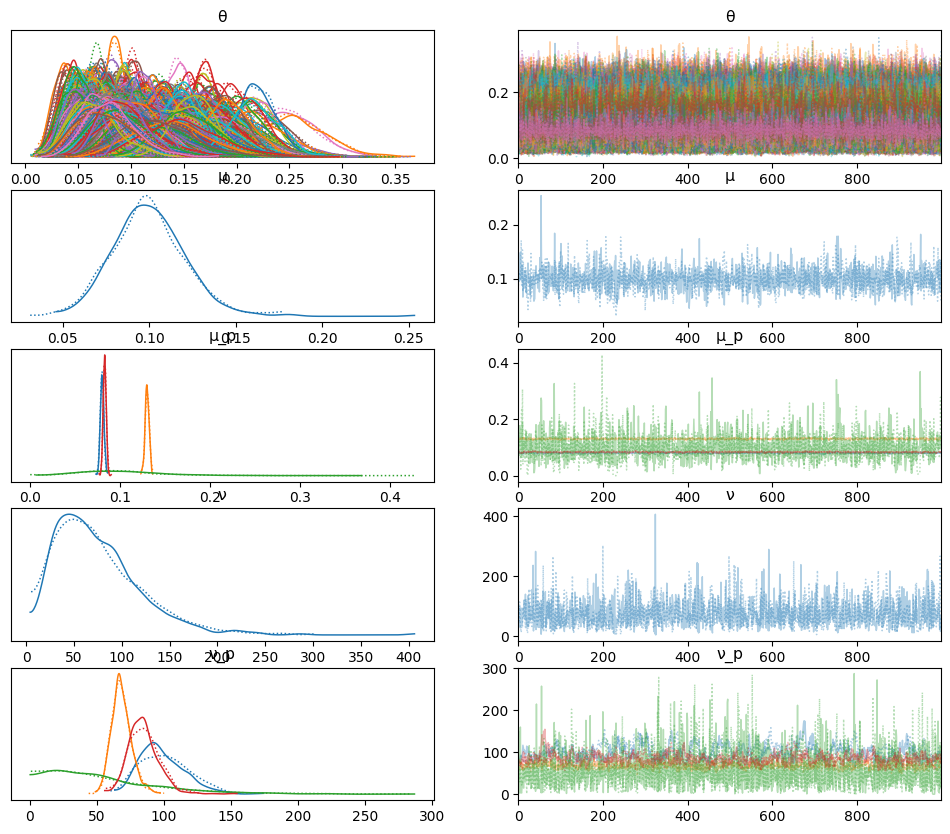

In [ ]:
az.plot_trace(idata_sccr_no_gk)
az.rhat(idata_sccr_no_gk)

The model without the goalkeepers seemed easier for pymc. By excluding the goalkeepers you lose information about a group of soccer players that effect the statistics, but you get data that is more accurate for other positions.